In [28]:
from collections import defaultdict

## Extract Useful Lines for Quick Glance at Perf

In [29]:
base_path = "/scratch/ddr8143/multiqa/baseline_runs_v0/"
run_name = "ambigqa_bm25_100.from_nq.bs_48.ws_4.t_0.s_0"
log_file = f"{base_path}{run_name}/train_dense_encoder.log"

In [30]:
extract_lines = {
    "checkpoint_model": "Reading saved model from",
    "train_datasets": "train_datasets: ",
    "dev_datasets": "dev_datasets: ",
    "aggregated_data_size": "Aggregated data size: ",
    "cleaned_data_size": "Total cleaned data size: ",
    "shard_info": "samples_per_shard=",
    "epoch_losses": "Epoch: ",
    "nll_validation": "NLL Validation: ",
    "best_checkpoint": "New Best validation checkpoint ",
    "avg_rank_validation": "Av.rank validation: average rank ",
}

In [31]:
log_lines = open(log_file).readlines()

In [32]:
useful_lines = defaultdict(list)
for l in log_lines:
    for k, v in extract_lines.items():
        if v in l:
            ldata = l.split(v)[-1].strip()
            vldata = v + ldata
            if vldata not in useful_lines[k]:
                useful_lines[k].append(vldata)

In [33]:
useful_lines['nll_validation']

['NLL Validation: loss = 1.782290. correct prediction ratio  1041/1536 ~  0.677734',
 'NLL Validation: loss = 1.367543. correct prediction ratio  1069/1536 ~  0.695964',
 'NLL Validation: loss = 1.053357. correct prediction ratio  1087/1536 ~  0.707682',
 'NLL Validation: loss = 0.924300. correct prediction ratio  1095/1536 ~  0.712891',
 'NLL Validation: loss = 0.875859. correct prediction ratio  1104/1536 ~  0.718750',
 'NLL Validation: loss = 0.850196. correct prediction ratio  1108/1536 ~  0.721354',
 'NLL Validation: loss = 0.836891. correct prediction ratio  1113/1536 ~  0.724609',
 'NLL Validation: loss = 0.836513. correct prediction ratio  1121/1536 ~  0.729818',
 'NLL Validation: loss = 0.840433. correct prediction ratio  1121/1536 ~  0.729818',
 'NLL Validation: loss = 0.860442. correct prediction ratio  1122/1536 ~  0.730469',
 'NLL Validation: loss = 0.902931. correct prediction ratio  1120/1536 ~  0.729167',
 'NLL Validation: loss = 0.961234. correct prediction ratio  1115

In [53]:
#y = [float(l.split(" ")[-1]) for l in useful_lines["nll_validation"]]
y = [float(l.split("loss = ")[-1].split(". ")[0]) for l in useful_lines["nll_validation"]]
x = [i + 1 for i in range(len(y))]

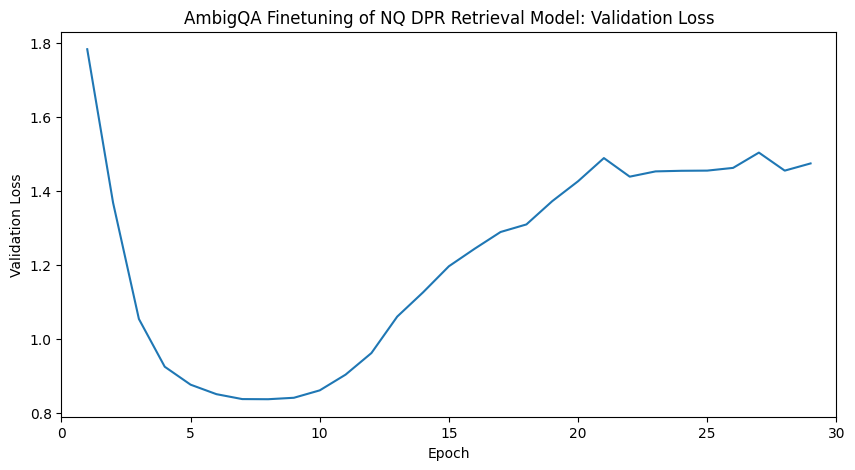

In [55]:
fig = plt.figure(figsize=(10,5))
#i = -1
#for k, v in data.items():
#    plt.bar(X_axis + (i * 0.2) , v, 0.2, label = k)
#    i += 1
#plt.bar(X_axis + 0.2, Zboys, 0.4, label = 'Boys')
plt.plot(x, y)
  
#plt.xticks(X_axis, ["%Ans@3", "%Ans@10", "%Ans@100"])
plt.xlabel("Epoch")
#plt.ylim([0, 100])
plt.xlim([0, 30])
plt.ylabel("Validation Loss")
plt.title("AmbigQA Finetuning of NQ DPR Retrieval Model: Validation Loss")
#plt.legend()
plt.show()

In [39]:
# Not useful bc the lr goes up 
train_loss = [float(l.split("loss=")[-1].split(",")[0]) for l in useful_lines["epoch_losses"] if "loss" in l]

In [38]:
useful_lines['best_checkpoint']

['New Best validation checkpoint /scratch/ddr8143/multiqa/baseline_runs_v0/ambigqa_bm25_100.from_nq.bs_48.ws_4.t_0.s_0/best_checkpoint.1',
 'New Best validation checkpoint /scratch/ddr8143/multiqa/baseline_runs_v0/ambigqa_bm25_100.from_nq.bs_48.ws_4.t_0.s_0/best_checkpoint.2',
 'New Best validation checkpoint /scratch/ddr8143/multiqa/baseline_runs_v0/ambigqa_bm25_100.from_nq.bs_48.ws_4.t_0.s_0/best_checkpoint.3',
 'New Best validation checkpoint /scratch/ddr8143/multiqa/baseline_runs_v0/ambigqa_bm25_100.from_nq.bs_48.ws_4.t_0.s_0/best_checkpoint.4',
 'New Best validation checkpoint /scratch/ddr8143/multiqa/baseline_runs_v0/ambigqa_bm25_100.from_nq.bs_48.ws_4.t_0.s_0/best_checkpoint.5',
 'New Best validation checkpoint /scratch/ddr8143/multiqa/baseline_runs_v0/ambigqa_bm25_100.from_nq.bs_48.ws_4.t_0.s_0/best_checkpoint.6',
 'New Best validation checkpoint /scratch/ddr8143/multiqa/baseline_runs_v0/ambigqa_bm25_100.from_nq.bs_48.ws_4.t_0.s_0/best_checkpoint.7',
 'New Best validation check

In [42]:
best_checkpoint = "/scratch/ddr8143/multiqa/baseline_runs_v0/ambigqa_bm25_100.from_nq.bs_48.ws_4.t_0.s_0/best_checkpoint.8"

In [ ]:
# Lets load the relevant data and then we can processes it as desired
# Goal: Recall at 1/3/10/100
#       - but, any of the aliases should only count as a single answer
#       - so first postprocess the dataset to get a list of lists of aliases, then do the checking
#       - we can check just the contexts where has_answer=True

In [1]:
import sh
import json

In [2]:
sh.ls("/scratch/ddr8143/multiqa/baseline_runs_v0/ambigqa_bm25_100.from_nq.bs_48.ws_4.t_0.s_0/checkpoint_8.ambigqa_dev.json")

/scratch/ddr8143/multiqa/baseline_runs_v0/ambigqa_bm25_100.from_nq.bs_48.ws_4.t_0.s_0/checkpoint_8.ambigqa_dev.json

In [3]:
original_file = json.load(open("/scratch/ddr8143/multiqa/downloads/data/ambigqa_light/dev.json"))
bm25_retrieval = json.load(open("/scratch/ddr8143/multiqa/processed_datasets/bm25.ambigqa_light.dev.h100.json__contexts"))
nq_retrieval = json.load(open("/scratch/ddr8143/multiqa/baseline_runs_v0/nq_downloaded_index_checkpoint.ambigqa_dev.json"))
ambigqa_retrieval = json.load(open("/scratch/ddr8143/multiqa/baseline_runs_v0/ambigqa_bm25_100.from_nq.bs_48.ws_4.t_0.s_0/checkpoint_8.ambigqa_dev.json"))

In [4]:
original_file[3]

{'annotations': [{'type': 'singleAnswer',
   'answer': ['mediocrity of the Cardinals,a then-21-year-old stadium,game attendance to dwindle']},
  {'type': 'multipleQAs',
   'qaPairs': [{'question': 'What ability caused the st louis cardinals move to arizona?',
     'answer': ['overall mediocrity of the Cardinals']},
    {'question': 'What physical issue caused the st louis cardinals move to arizona?',
     'answer': ['old stadium']},
    {'question': 'What fan issue caused the st louis cardinals move to arizona?',
     'answer': ['game attendance to dwindle']}]}],
 'id': '8630912480840635425',
 'question': 'Why did the st louis cardinals move to arizona?'}

In [13]:
original_file[2]

{'annotations': [{'type': 'singleAnswer', 'answer': ['1950']},
  {'type': 'singleAnswer', 'answer': ['1950']}],
 'id': '7336174019902289593',
 'question': 'When was the first remote control tv invented?'}

In [16]:
original_file[3]

{'annotations': [{'type': 'singleAnswer',
   'answer': ['mediocrity of the Cardinals,a then-21-year-old stadium,game attendance to dwindle']},
  {'type': 'multipleQAs',
   'qaPairs': [{'question': 'What ability caused the st louis cardinals move to arizona?',
     'answer': ['overall mediocrity of the Cardinals']},
    {'question': 'What physical issue caused the st louis cardinals move to arizona?',
     'answer': ['old stadium']},
    {'question': 'What fan issue caused the st louis cardinals move to arizona?',
     'answer': ['game attendance to dwindle']}]}],
 'id': '8630912480840635425',
 'question': 'Why did the st louis cardinals move to arizona?'}

In [31]:
original_file[6]['annotations'][0]

{'type': 'multipleQAs',
 'qaPairs': [{'question': 'Who is the 4th chairman of african union commission?',
   'answer': ['Moussa Faki', 'Moussa Faki Mahamat']},
  {'question': 'Who is the 3rd chairman of african union commission?',
   'answer': ['Nkosazana Clarice Dlamini-Zuma', 'Nkosazana Dlamini-Zuma']},
  {'question': 'Who is the 2nd chairman of african union commission?',
   'answer': ['Jean Ping']}]}

In [18]:
def process_ambigqa_qdata(qdata):
    the_answers = (None, None)
    for ann in qdata['annotations']:
        ans = process_ambigqa_annotation(ann)
        if ann['type'] == 'multipleQAs':
            return ans
        elif the_answers[0] == None:
            the_answers = (ann['type'], ans)
    return the_answers[1]

In [19]:
def process_ambigqa_annotation(ann):
    if ann['type'] == 'singleAnswer':
        return [ann['answer']]
    elif ann['type'] == 'multipleQAs':
        return [qap['answer'] for qap in ann['qaPairs']]
    else:
        assert False

In [20]:
# Ground Truth
ground_truth = {}
for qdata in original_file:
    ground_truth[qdata['question']] = process_ambigqa_qdata(qdata)

In [8]:
bm25_retrieval_list = list(bm25_retrieval.values())

In [9]:
bm25_retrieval_list[0]['question']

'Who plays the doctor in dexter season 1?'

In [81]:
ground_truth[bm25_retrieval_list[0]['question']]

[['Tony Goldwyn', 'Goldwyn']]

In [83]:
bm25_retrieval_list[0]['contexts'][0]

{'docid': '2499310',
 'score': '12.204408',
 'text': '"Denise Crosby"\n""Key West"". She also appeared in two episodes of the cable television series ""Red Shoe Diaries"", playing a different character in each episode. Crosby had a small recurring role in Aaron Spelling\'s prime time drama, ""Models Inc"", a spin-off from ""Melrose Place"". She was a guest star on the eighth season of ""The X-Files"" for two episodes, in which she plays a doctor who examined Agent Scully\'s baby. In 1991, she was a guest star in ""The Deadly Nightshade"", a first season ""The Flash"" episode as Dr. Rebecca Frost. In 2006, she was a guest star in ""Dexter"" as Dexter\'s',
 'has_answer': False}

In [9]:
def answers_in_context(context, answer_llist):
    #if True:
    if False:
        print("Context:")
        print(context)
        print()
        print("Answers:")
        print(answer_llist)
        print()
    
    ans_in_context = []
    for alist in answer_llist:
        a_in_context = False
        for a in alist:
            if a in context:
                a_in_context = True
                #print(f"found {a} in context")
                break
        ans_in_context.append(a_in_context)
    return ans_in_context

In [10]:
def get_index_of_answers_bm25(bm25_retrieval_list, ground_truth):
    indices_of_answers = []
    for dev_idx in range(len(bm25_retrieval_list)):
        retrieved = bm25_retrieval_list[dev_idx]
        gt_ans = ground_truth[retrieved['question']]
        index_true = [None for _ in range(len(gt_ans))]
        for ctx_idx in range(len(retrieved['contexts']) ):
            a_in_c = answers_in_context(retrieved['contexts'][ctx_idx]['text'], gt_ans)
            for a_idx, a in enumerate(a_in_c):
                if a and index_true[a_idx] is None:
                    index_true[a_idx] = ctx_idx
            if all([it is not None for it in index_true]):
                break
        indices_of_answers.append((retrieved['question'], index_true))
    return indices_of_answers

In [11]:
indices_of_answers = get_index_of_answers_bm25(bm25_retrieval_list, ground_truth)

In [12]:
def ioa_to_rankPatK(indices_of_answers, k):
    num_at_k = []
    rankP_at_k = []
    for dev_idx in range(len(indices_of_answers)):
        num_ans = len(indices_of_answers[dev_idx][1])
        num_below_k = 0
        for ioa in indices_of_answers[dev_idx][1]:
            if ioa is not None and ioa < k:
                num_below_k += 1
        p_below_k = num_below_k / num_ans
        num_at_k.append(num_below_k)
        rankP_at_k.append(p_below_k)
    return sum(rankP_at_k) / len(rankP_at_k), rankP_at_k, num_at_k

In [13]:
avg_rankPat100, _, _ = ioa_to_rankPatK(indices_of_answers, 100)
avg_rankPat10, _, _ = ioa_to_rankPatK(indices_of_answers, 10)
avg_rankPat3, _, _ = ioa_to_rankPatK(indices_of_answers, 3)

In [17]:
print(f"|     BM25 %Ans at 100, 10, 3     || {avg_rankPat100*100.0:0.2f} | {avg_rankPat10*100.0:0.2f} | {avg_rankPat3*100.0:0.2f} |")
avg_rankPat100, avg_rankPat10, avg_rankPat3

|     BM25 %Ans at 100, 10, 3     || 70.14 | 49.11 | 34.37 |


(0.7014059438469271, 0.4911128785532784, 0.3436549793096648)

In [23]:
num_gt_answers = []
for k, v in ground_truth.items():
    num_gt_answers.append(len(v))
    if len(v) > 5:
        print(k, v)
    

Voice of alvin in alvin and the chipmunks? [['Justin Long'], ['Ross Bagdasarian Jr.'], ['Ross Bagdasarian, Jr.'], ['Ross Bagdasarian Jr.'], ['Justin Long'], ['Ross Bagdasarian, Jr.'], ['Ross Bagdasarian Sr.']]
How many championships did the cleveland browns win? [['4'], ['4'], ['8'], ['11'], ['3'], ['8'], ['12'], ['3'], ['3'], ['6']]
Who played the weasley brothers in harry potter? [['Richard Fish'], ['Chris Rankin'], ['James Phelps'], ['Rupert Grint'], ['Oliver Phelps'], ['Domhnall Gleeson']]
Who wrote the music for once more with feeling? [['Sam Duckworth', 'Get Cape. Wear Cape. Fly', 'Samuel Lloyd "Sam" Duckworth', ' Samuel Lloyd Duckworth'], ['Shirley Nelson'], ['Kris Kristofferson and Shel Silverstein'], ['Nick Cave and the Bad Seeds'], ['Paul Hsu'], ['Joss Whedon', 'Joseph Hill Whedon'], ['Franz Liszt, Ludwig van Beethoven, and Richard Wagner']]
Who's face is on the 2 dollar bill? [['Alexander Hamilton'], ['Thomas Jefferson'], ['General Winfield Scott Hancock'], ['William Windom'

[1,
 1,
 1,
 3,
 1,
 1,
 3,
 2,
 1,
 3,
 3,
 1,
 3,
 4,
 4,
 2,
 2,
 2,
 2,
 2,
 2,
 5,
 2,
 3,
 5,
 4,
 1,
 7,
 3,
 1,
 2,
 2,
 1,
 1,
 2,
 3,
 2,
 2,
 10,
 2,
 1,
 3,
 5,
 6,
 1,
 5,
 3,
 7,
 1,
 1,
 9,
 3,
 2,
 3,
 2,
 1,
 6,
 3,
 2,
 4,
 1,
 1,
 7,
 1,
 4,
 1,
 1,
 1,
 3,
 1,
 2,
 3,
 4,
 2,
 1,
 3,
 2,
 2,
 2,
 7,
 1,
 1,
 1,
 3,
 2,
 1,
 1,
 3,
 1,
 2,
 2,
 3,
 2,
 1,
 2,
 2,
 2,
 3,
 2,
 2,
 1,
 6,
 1,
 3,
 2,
 3,
 4,
 1,
 2,
 3,
 2,
 2,
 1,
 1,
 2,
 2,
 3,
 2,
 3,
 5,
 41,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 3,
 1,
 1,
 4,
 1,
 5,
 2,
 2,
 1,
 4,
 3,
 1,
 1,
 1,
 5,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 3,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 4,
 4,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 5,
 3,
 1,
 2,
 1,
 5,
 1,
 6,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 3,
 1,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 5,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 3,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 3,
 2,
 4,
 8,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 2

In [21]:
min(num_gt_answers), max(num_gt_answers), sum(num_gt_answers)/len(num_gt_answers)

(1, 41, 2.2712287712287713)

In [31]:
def get_index_of_answers_nq(nq_retrieval_list, ground_truth):
    # TODO
    q_not_in_gt = []
    indices_of_answers = []
    for dev_idx in range(len(nq_retrieval_list)):
        retrieved = nq_retrieval_list[dev_idx]
        if retrieved['question'] not in ground_truth:
            q_not_in_gt.append(retrieved['question'])
            continue
        gt_ans = ground_truth[retrieved['question']]
        index_true = [None for _ in range(len(gt_ans))]
        for ctx_idx in range(len(retrieved['ctxs']) ):
            a_in_c = answers_in_context(retrieved['ctxs'][ctx_idx]['text'], gt_ans)
            for a_idx, a in enumerate(a_in_c):
                if a and index_true[a_idx] is None:
                    index_true[a_idx] = ctx_idx
            if all([it is not None for it in index_true]):
                break
        indices_of_answers.append((retrieved['question'], index_true))
    return indices_of_answers, q_not_in_gt

In [34]:
nq_ioas, _ = get_index_of_answers_nq(nq_retrieval, ground_truth)

In [36]:
nqavg_rankPat100, _, _ = ioa_to_rankPatK(nq_ioas, 100)
nqavg_rankPat10, _, _ = ioa_to_rankPatK(nq_ioas, 10)
nqavg_rankPat3, _, _ = ioa_to_rankPatK(nq_ioas, 3)

In [37]:
print(f"|      NQ  %Ans at 100, 10, 3     || {nqavg_rankPat100*100.0:0.2f} | {nqavg_rankPat10*100.0:0.2f} | {nqavg_rankPat3*100.0:0.2f} |")
nqavg_rankPat100, nqavg_rankPat10, nqavg_rankPat3

|      NQ  %Ans at 100, 10, 3     || 81.77 | 68.27 | 53.41 |


(0.8176688780957067, 0.6826838428460815, 0.5340976773500731)

In [38]:
ab_ioas, qnig = get_index_of_answers_nq(ambigqa_retrieval, ground_truth)

In [40]:
abavg_rankPat100, _, _ = ioa_to_rankPatK(ab_ioas, 100)
abavg_rankPat10, _, _ = ioa_to_rankPatK(ab_ioas, 10)
abavg_rankPat3, _, _ = ioa_to_rankPatK(ab_ioas, 3)

In [41]:
print(f"|      AB  %Ans at 100, 10, 3     || {abavg_rankPat100*100.0:0.2f} | {abavg_rankPat10*100.0:0.2f} | {abavg_rankPat3*100.0:0.2f} |")
abavg_rankPat100, abavg_rankPat10, abavg_rankPat3

|      AB  %Ans at 100, 10, 3     || 83.62 | 67.50 | 52.03 |


(0.8361801149269629, 0.6750260747930608, 0.5202742174105417)

In [5]:
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt 

In [11]:
data = {
    "BM25": [34.37, 49.11, 70.14],
    "NQ_Retriever": [53.41, 68.27, 81.77],
    "AmbigQA_Finetuned": [52.03, 67.50, 83.62],
}

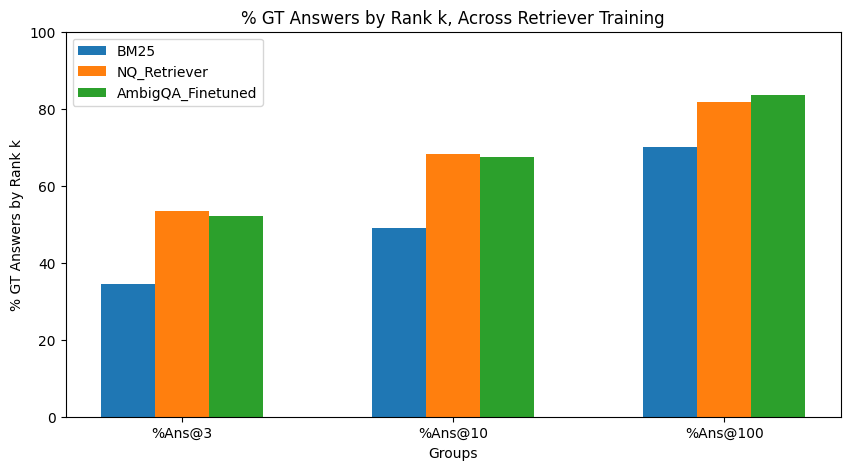

In [16]:

X_axis = np.arange(3)

fig = plt.figure(figsize=(10,5))
i = -1
for k, v in data.items():
    plt.bar(X_axis + (i * 0.2) , v, 0.2, label = k)
    i += 1
#plt.bar(X_axis + 0.2, Zboys, 0.4, label = 'Boys')
  
plt.xticks(X_axis, ["%Ans@3", "%Ans@10", "%Ans@100"])
plt.xlabel("Groups")
plt.ylim([0, 100])
plt.ylabel("% GT Answers by Rank k")
plt.title("% GT Answers by Rank k, Across Retriever Training")
plt.legend()
plt.show()

In [22]:
nq_retrieval[0]

{'question': 'Who plays the doctor in dexter season 1?',
 'answers': ['Goldwyn', 'Tony Goldwyn'],
 'ctxs': [{'id': 'wiki:13691524',
   'title': 'Dexter (season 1)',
   'text': 'be more intimate. Christian Camargo appears as Rudy Cooper and is a recurring character until the end of the season. The show\'s first season received generally favorable reviews from critics; it was praised as "bold, different and exciting, with a central character and performance that take your breath away" by the "New York Daily News". "The Wall Street Journal" saw "the grotesqueries of "Dexter"" as "not something that can easily be dismissed with the old "\'you don\'t have to watch\' line", and concluded that "We do have to live among the viewers who will be desensitized, or aroused, by this',
   'score': '77.18717',
   'has_answer': False},
  {'id': 'wiki:965707',
   'title': "Dexter's Laboratory",
   'text': 'Justice Friends" consists of Major Glory (voiced by Rob Paulsen), Valhallen (voiced by Tom Kenny),

In [29]:
indices_of_answers[6]

('Who is the current chairman of african union commission?', [0, 40, 10])

In [42]:
dev_idx = 6
num_ans = len(indices_of_answers[dev_idx][1])
k = 100
num_below_k = 0
for ioa in indices_of_answers[dev_idx][1]:
    if ioa is not None and ioa < k:
        num_below_k += 1
p_below_k = num_below_k / num_ans

In [43]:
print(num_below_k)
print(p_below_k)

3
1.0


In [140]:
dev_idx = 6
retrieved = bm25_retrieval_list[dev_idx]
gt_ans = ground_truth[retrieved['question']]
print(retrieved['question'], gt_ans)
index_true = [None for _ in range(len(gt_ans))]

Who is the current chairman of african union commission? [['Moussa Faki', 'Moussa Faki Mahamat'], ['Nkosazana Clarice Dlamini-Zuma', 'Nkosazana Dlamini-Zuma'], ['Jean Ping']]


In [141]:
index_true

[None, None, None]

In [142]:
for ctx_idx in range(len(retrieved['contexts']) ):
    a_in_c = answers_in_context(retrieved['contexts'][ctx_idx]['text'], gt_ans)
    for a_idx, a in enumerate(a_in_c):
        if a and index_true[a_idx] is None:
            index_true[a_idx] = ctx_idx
    print(a_in_c)
    print(index_true)
    if all([it is not None for it in index_true]):
        break

Context:
"African Union High Representative for Infrastructure Development"
the African Union Commission. African Union High Representative for Infrastructure Development The African Union High Representative for Infrastructure Development post was created in October 2018 by the African Union Commission Chair Moussa Faki The first and current High Representative is Raila Odinga, Leader of the Opposition and former Prime Minister of Kenya (2008-2013), who was appointed on 20 October 2018 by the Chairperson of the African Union Commission. Prior to this appointment, the Directorate of Trade and Industry was headed by Elisabeth Tankeu. The High Representative is tasked with working to support and strengthen the efforts of the Commission’s relevant

Answers:
[['Moussa Faki', 'Moussa Faki Mahamat'], ['Nkosazana Clarice Dlamini-Zuma', 'Nkosazana Dlamini-Zuma'], ['Jean Ping']]

found Moussa Faki in context
[True, False, False]
[0, None, None]
Context:
"African Union High Representative for In